In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import itertools
import pywt # for deniosing time-series wavelet


pd.set_option('display.max_columns', 50)
plt.style.use('bmh')
color_pal=plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle=cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# Read the data
INPUT_DIR='m5-forecasting-accuracy/'
cal_data=pd.read_csv(INPUT_DIR+'calendar.csv')
salestv_data=pd.read_csv(INPUT_DIR+'sales_train_validation.csv')
ss_data=pd.read_csv(INPUT_DIR+'sample_submission.csv')
sellp_data=pd.read_csv(INPUT_DIR+'sell_prices.csv')

In [3]:
salestv_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [5]:
cal_data['date'] = pd.to_datetime(cal_data['date'])

In [6]:
ids = 0
d_cols = [i for i in salestv_data.columns if 'd_' in i]
example = salestv_data.loc[ids][d_cols].reset_index()
example.columns = ['d' , 'sales']
example = example.set_index('d').merge(cal_data.set_index('d')['date'], left_index=True, right_index=True)
example = example.set_index('date')

In [7]:
example

,sales
date,
2011-01-29,0
2011-01-30,0
2011-01-31,0
2011-02-01,0
2011-02-02,0
...,...
2016-04-20,1
2016-04-21,3
2016-04-22,0


# Plotting Trend, seasonality, residual of a Time-series

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
result = seasonal_decompose(example, model='additive', period=365)

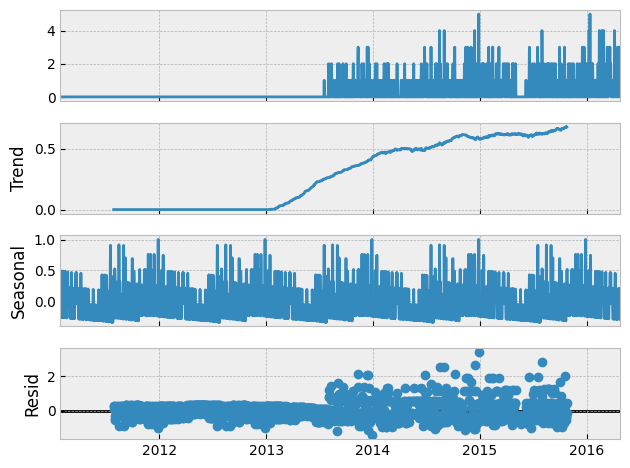

In [10]:
result.plot()
plt.show()

# Checking for Stationarity

1. Plotting rolling mean and variance is a good statistic to see if our series is stationary or non-stationary.
 * If rolling statistic show a clear trend (upward or downward)-***mean*** and show varying variance (increasing or decresing amplitude)-***std*** then, a series is possibly non-stationary

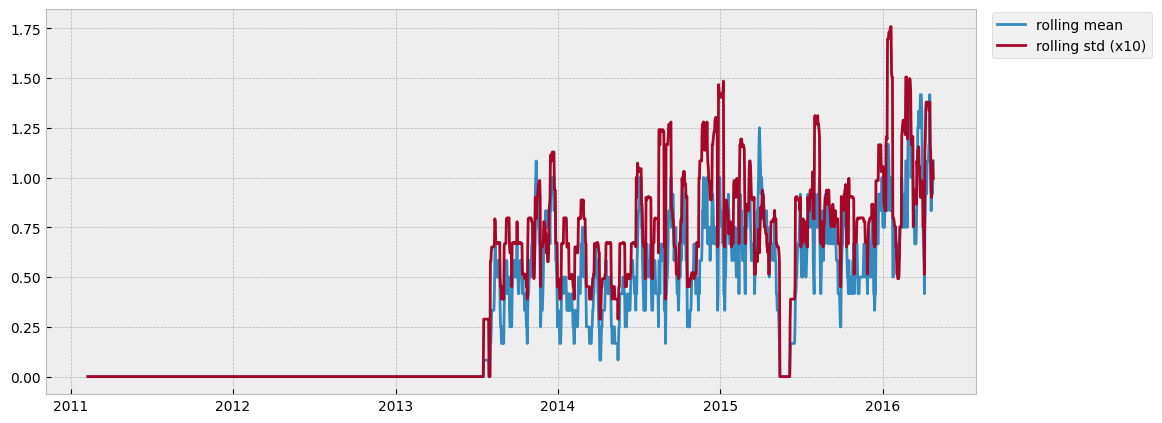

In [12]:
fig, ax = plt.subplots(1,figsize=(12, 5))
# ax.plot(example.index, example.sales, label='raw data')
# Window of 12 is choosen as we have 12-period seasonality
ax.plot(example.sales.rolling(window=12).mean(), label="rolling mean") 
ax.plot(example.sales.rolling(window=12).std(), label="rolling std (x10)")
ax.legend(bbox_to_anchor=(1.01,1.01))

The series is non-stationary as can be seen by the above plot, both mean and variance are varying

2. Augmented Dickey-fuller test
    * This test will give a result called a “test-statistic”, based on which you can say, with different levels (or percentage) of confidence, if the time-series is stationary or not.

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
def adfuller_test(data):
    print("Is the data stationary?")
    dftest = adfuller(data, autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values:")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k,v,"not" if v<dftest[0] else "",100-int(k[:-1])))

In [15]:
adfuller_test(example.sales)

Is the data stationary?
Test statistic = -2.118
P-value = 0.237
Critical values:
	1%: -3.433814658052138 - The data is not stationary with 99% confidence
	5%: -2.8630704504871605 - The data is not stationary with 95% confidence
	10%: -2.56758475462613 - The data is not stationary with 90% confidence


The above value also proves that our series is non-stationary 

# Making series stationary

1. De-trending the series - We remove the trend in the series
    * In order to do that, we will create a de-trended column whose values are subtracted by rollng mean and divided by rolling variance

In [16]:
example['detrended_sales'] = (example['sales'] - example.sales.rolling(window=12).mean())/example.sales.rolling(window=12).std()

In [17]:
example

,sales,detrended_sales
date,,
2011-01-29,0,NaN
2011-01-30,0,NaN
2011-01-31,0,NaN
2011-02-01,0,NaN
2011-02-02,0,NaN
...,...,...
2016-04-20,1,0.092558
2016-04-21,3,1.768755
2016-04-22,0,-0.845926


##### Performing rolling analysis and adfuller test to see if our de-trended series is stationary or not

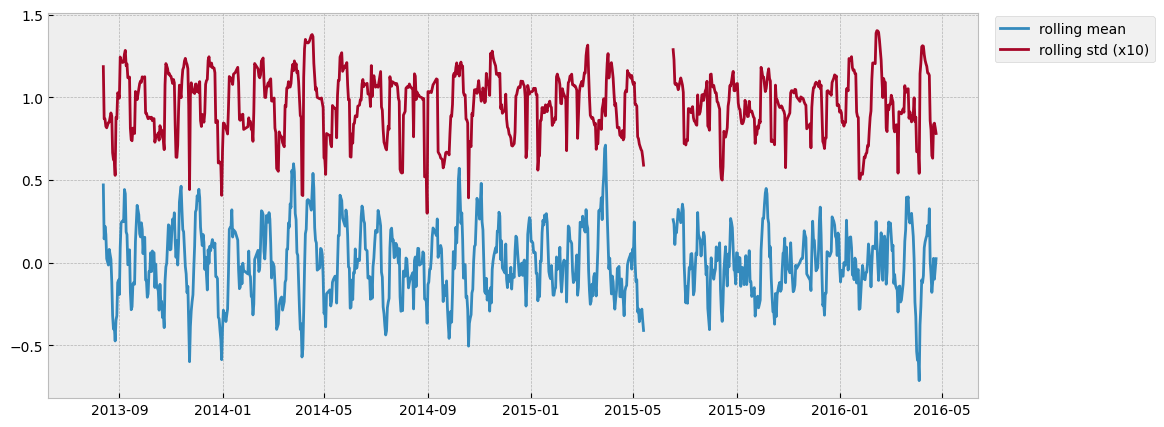

In [18]:
fig, ax = plt.subplots(1,figsize=(12, 5))
# ax.plot(example.index, example.detrended_sales, label='de-trended data')
# Window of 12 is choosen as we have 12-period seasonality
ax.plot(example.detrended_sales.rolling(window=12).mean(), label="rolling mean") 
ax.plot(example.detrended_sales.rolling(window=12).std(), label="rolling std (x10)")
ax.legend(bbox_to_anchor=(1.01,1.01))

In [19]:
adfuller_test(example.detrended_sales.dropna())

Is the data stationary?
Test statistic = -11.284
P-value = 0.000
Critical values:
	1%: -3.437137538234527 - The data is  stationary with 99% confidence
	5%: -2.8645366106945414 - The data is  stationary with 95% confidence
	10%: -2.568365556798649 - The data is  stationary with 90% confidence


##### As it can be seen through both the above tests, our detrended series is free of trend but, we still have a seasonal component visible in the plotting analysis graph (the variance/std has an increasing decresing amplitude)

2. De-seasonling the series - We can do this by differencing which states, seasonal or cyclic patterns can be removed by subtracting periodical values (this subtraction is done on detrended series)
    * If data is 12-month seasonal, subtracting the series with a 12-lag difference series will give a "flatter" series 

In [20]:
example['deseasonal_sales'] = example['detrended_sales'] - example['detrended_sales'].shift(12)

In [21]:
example

,sales,detrended_sales,deseasonal_sales
date,,,
2011-01-29,0,NaN,NaN
2011-01-30,0,NaN,NaN
2011-01-31,0,NaN,NaN
2011-02-01,0,NaN,NaN
2011-02-02,0,NaN,NaN
...,...,...,...
2016-04-20,1,0.092558,0.757313
2016-04-21,3,1.768755,1.708323
2016-04-22,0,-0.845926,-1.510681


##### Performing rolling analysis and adfuller test to see if our de-seasonal series is stationary or not

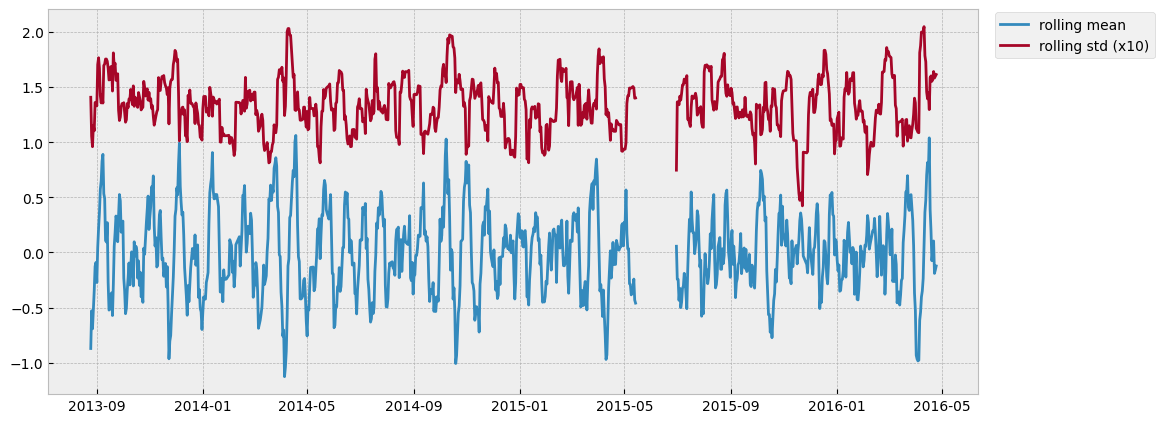

In [22]:
fig, ax = plt.subplots(1,figsize=(12, 5))
# ax.plot(example.index, example.deseasonal_sales, label="12 lag differenced de-trended data")
ax.plot(example.deseasonal_sales.rolling(window=12).mean(), label="rolling mean");
ax.plot(example.deseasonal_sales.rolling(window=12).std(), label="rolling std (x10)");
ax.legend(bbox_to_anchor=(1.01, 1.01))


In [23]:
adfuller_test(example.deseasonal_sales.dropna())

Is the data stationary?
Test statistic = -12.961
P-value = 0.000
Critical values:
	1%: -3.437303541847512 - The data is  stationary with 99% confidence
	5%: -2.864609814371715 - The data is  stationary with 95% confidence
	10%: -2.5684045480287296 - The data is  stationary with 90% confidence


##### As it can be seen through both the above tests, our deseasonal series is free of trend and seasonality

# Autocorrelation plots (ACF & APCF)

***Lags*** = The amount by which we are shifting the time-series data to find correlations of current sales data with previous time-stamp sales data  
***Auto-Correlation*** = ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information  
***Partial Auto-Correlation*** = It finds the correlations in time-series by removing the indirect correlations as in AC 

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

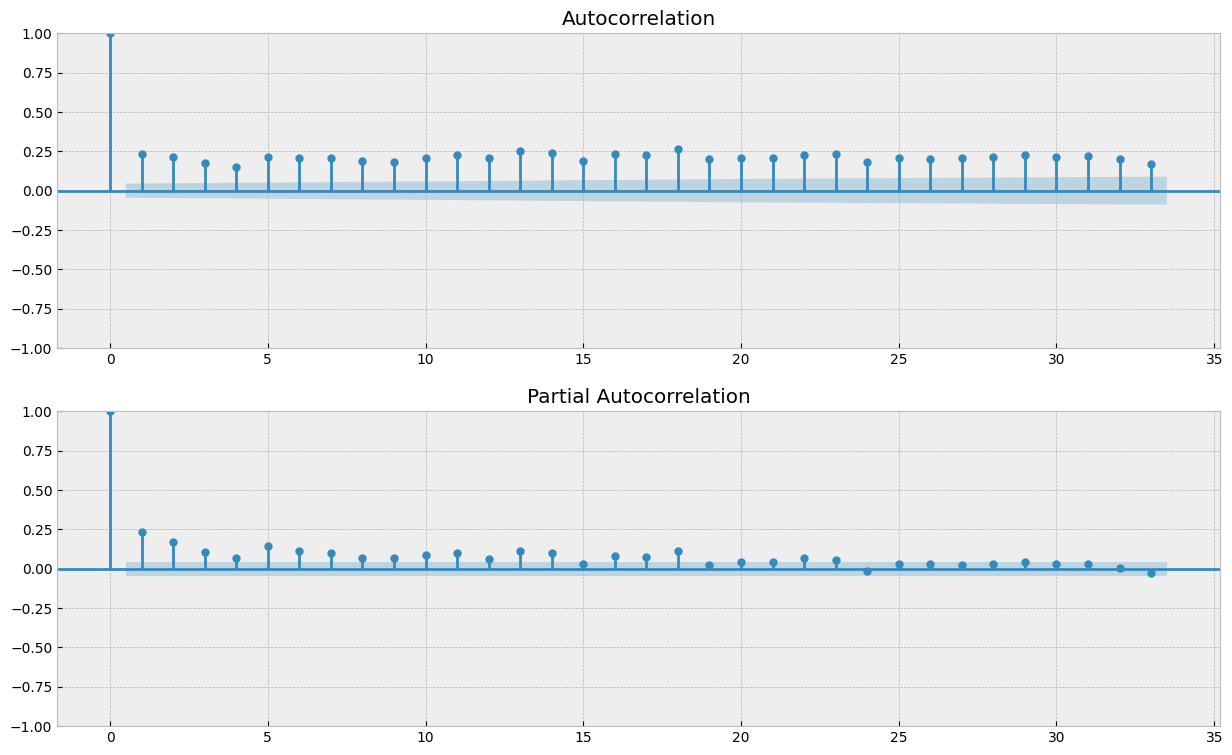

In [25]:
fig, ax = plt.subplots(2, figsize=(15,9))
ax[0] = plot_acf(example.sales.dropna(), ax=ax[0])
ax[1] = plot_pacf(example.sales.dropna(), ax=ax[1])

##### We can use ACF and PACF plot to get the AR(AutoRegression) term and MA(Moving Average) term respectively in ARMA model

* Identification of AR part is best done with PACF
    * For an AR part, the PACF "shuts off" past the order of model. "shuts off" theoratically means that the pacf is equal to 0 past that value

* Identification of MA part is best done with ACF
    * For an MA part, the pacf does not shut off, but is tampering around 0 in some manner. And the ACF plot has an exponential decrease rather than a sudden shut off as well

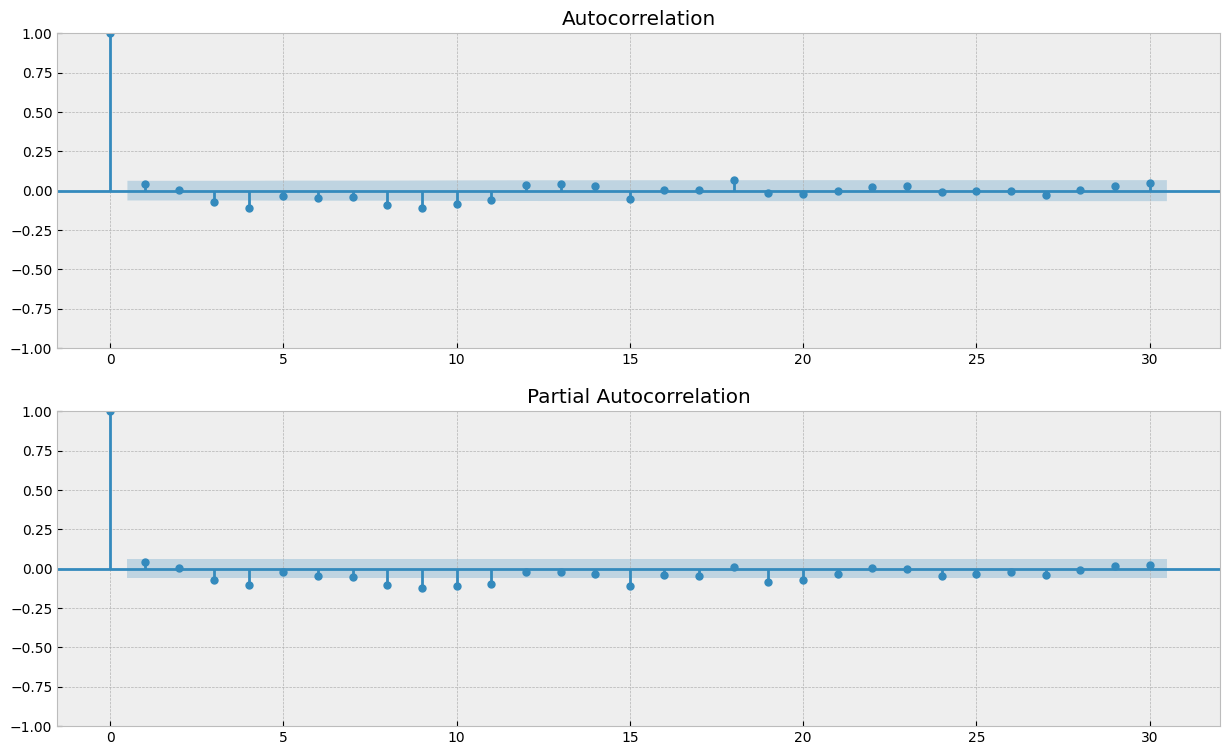

In [26]:
fig, ax = plt.subplots(2, figsize=(15,9))
ax[0] = plot_acf(example.detrended_sales.dropna(), ax=ax[0])
ax[1] = plot_pacf(example.detrended_sales.dropna(), ax=ax[1])

As per our plots, we can have ***AR to be 0 or 1*** and ***MA to be 1 or 2***

# Modeling

1. ARIMA model - AutoRegressive Integrated MovingAverage model
    * It has three components,
        * p - AR part
        * d - differencing part
        * q - MA part

##### Performing grid search to find the best parameters for ARIMA model 

In [25]:
import statsmodels.api as sm
p=d=q=range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
aics = []
params = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        data = example['sales'].astype('int64').values
        model = sm.tsa.statespace.SARIMAX(data, order=param, seasonal_order=param_seasonal)
        result = model.fit()
        aics.append(result.aic)
        params.append((param, param_seasonal))
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, result.aic))

index = aics.index(min(aics))
print("Minimum values: " + str(params[index]) + str(aics[index]))

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13585D+00    |proj g|=  1.76147D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     11      1     0     0   1.758D-05   1.136D+00
  F =   1.1358527987314864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4347.772807946667
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4182.690868095482
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25982D+00    |proj g|=  7.30586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   3.555D-07   1.260D+00
  F =   1.2598146145451730     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4822.050715249832
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  9.97430D-01    |proj g|=  3.79324D-01

At iterate   10    f=  9.69565D-01    |proj g|=  3.03847D-03

At iterate   15    f=  9.68165D-01    |proj g|=  7.17247D-02

At iterate   20    f=  9.64255D-01    |proj g|=  2.62244D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   2.442D-06   9.642D-01
  F =  0.96424919733624015     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3695.217429008455
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00045D+00    |proj g|=  1.59032D-01

At iterate    5    f=  9.73746D-01    |proj g|=  6.40909D-02

At iterate   10    f=  9.59890D-01    |proj g|=  1.05994D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   2.735D-05   9.599D-01
  F =  0.95988844490135317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3678.5331901925774
RUNNING THE L-

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4087.908421535489
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25971D+00    |proj g|=  2.43453D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   2.535D-05   1.260D+00
  F =   1.2597093425015793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4823.647944411043
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.68207D-01    |proj g|=  1.15823D-01

At iterate   10    f=  9.58504D-01    |proj g|=  1.33896D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     19      1     0     0   1.635D-05   9.585D-01
  F =  0.95850406994478277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3673.236571608739
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06898D+00    |proj g|=  1.24693D-01

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   4.875D-06   1.058D+00
  F =   1.0580954540081220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4054.2732070350744
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03649D+00    |proj g|=  2.12149D-01

At iterate    5    f=  9.93765D-01    |proj g|=  1.68843D-01

At iterate   10    f=  9.67361D-01    |proj g|=  6.26999D-03

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.12705D+00    |proj g|=  1.79994D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   7.996D-07   1.127D+00
  F =   1.1270450043317735     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4318.074186573365
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05734D+00    |proj g|=  4.78350D-01


 This problem is unconstrained.



At iterate    5    f=  9.79746D-01    |proj g|=  3.99157D-02

At iterate   10    f=  9.58544D-01    |proj g|=  1.07161D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   1.708D-05   9.585D-01
  F =  0.95848332298982097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3675.157193759055
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25561D+00    |proj g|=  6.01393D-04

           * *

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35555D+00    |proj g|=  2.81881D-01


 This problem is unconstrained.



At iterate    5    f=  1.28776D+00    |proj g|=  6.87227D-02

At iterate   10    f=  1.26505D+00    |proj g|=  1.85999D-02

At iterate   15    f=  1.26397D+00    |proj g|=  2.52730D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     21      1     0     0   4.584D-06   1.264D+00
  F =   1.2639633519374049     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:4839.923784512512
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   4.753D-06   1.255D+00
  F =   1.2547154058392744     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:4804.541142741064
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25491D+00    |proj g|=  2.21548D-02

At iterate    5    f=  1.25474D+00    |proj g|=  4.29440D-03

At iterate   10    f=  1.25398D+00    |proj g|=  1.96506D-02

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.27409D+00    |proj g|=  3.00559D-02

At iterate   10    f=  1.26322D+00    |proj g|=  3.03814D-03

At iterate   15    f=  1.26296D+00    |proj g|=  8.40398D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   9.528D-05   1.263D+00
  F =   1.2629569207186038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:4838.073178669378
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.31709D-01    |proj g|=  4.78606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   1.283D-06   9.317D-01
  F =  0.93166889056271462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3570.565175292946
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34524D+00    |proj g|=  9.40854D-02

At iterate    5    f=  1.28026D+00    |proj g|=  1.04830D-02


 This problem is unconstrained.



At iterate   10    f=  1.26346D+00    |proj g|=  1.37212D-02

At iterate   15    f=  1.26161D+00    |proj g|=  8.15467D-04

At iterate   20    f=  1.26137D+00    |proj g|=  5.52103D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     29      1     0     0   3.502D-05   1.261D+00
  F =   1.2613588394612167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:4829.958919778615
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  9.69128D-01    |proj g|=  4.07020D-02

At iterate   10    f=  9.42125D-01    |proj g|=  9.52570D-04

At iterate   15    f=  9.41873D-01    |proj g|=  9.75963D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   1.345D-05   9.419D-01
  F =  0.94187310851754869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:3609.6065131881414
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00924D+00    |proj g|=  1.23925D-01

At iterate    5    f=  9.49953D-01    |proj g|=  1.15785D-01

At iterate   10    f=  9.31710D-01    |proj g|=  4.93649D-03

At iterate   15    f=  9.31671D-01    |proj g|=  1.59999D-04

At iterate   20    f=  9.31668D-01    |proj g|=  2.95697D-03

At iterate   25    f=  9.31635D-01    |proj g|=  6.87841D-03

At iterate   30    f=  9.31586D-01    |proj g|=  2.58298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f=  1.13319D+00    |proj g|=  9.38582D-03

At iterate   15    f=  1.12925D+00    |proj g|=  3.83738D-03

At iterate   20    f=  1.12886D+00    |proj g|=  1.36365D-04

At iterate   25    f=  1.12882D+00    |proj g|=  4.04412D-03

At iterate   30    f=  1.12881D+00    |proj g|=  1.18950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     52      1     0     0   1.610D-04   1.129D+00
  F =   1.1288122129746516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:4324.835526841017
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  1.06035D+00    |proj g|=  2.50138D-01

At iterate   10    f=  9.46228D-01    |proj g|=  5.02228D-02

At iterate   15    f=  9.41824D-01    |proj g|=  6.12903D-04

At iterate   20    f=  9.41820D-01    |proj g|=  1.13156D-04

At iterate   25    f=  9.41819D-01    |proj g|=  2.26102D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   2.261D-06   9.418D-01
  F =  0.94181863794210940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:3611.3981087665106
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      4      1     0     0   7.820D-06   1.260D+00
  F =   1.2597139053413924     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:4823.665401836167
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05598D+00    |proj g|=  4.80232D-01


 This problem is unconstrained.



At iterate    5    f=  9.67919D-01    |proj g|=  1.14183D-01

At iterate   10    f=  9.58389D-01    |proj g|=  3.17798D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     18      1     0     0   1.421D-05   9.584D-01
  F =  0.95838839667580611     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:3672.794005681634
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07720D+00    |proj g|=  1.70604D-01

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.793D-06   1.051D+00
  F =   1.0508698904678746     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:4026.628200930088
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02923D+00    |proj g|=  1.02807D-01

At iterate    5    f=  9.82686D-01    |proj g|=  1.79779D-01

At iterate   10    f=  9.67359D-01    |proj g|=  4.39331D-03

At iterate   1

 This problem is unconstrained.



At iterate    5    f=  1.12705D+00    |proj g|=  1.65785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.169D-06   1.127D+00
  F =   1.1270453462932670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:4318.07549491804
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05701D+00    |proj g|=  4.77690D-01


 This problem is unconstrained.



At iterate    5    f=  9.79761D-01    |proj g|=  3.99828D-02

At iterate   10    f=  9.58426D-01    |proj g|=  1.07761D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   2.342D-05   9.584D-01
  F =  0.95836401606502064     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:3674.7007254647688
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87924D-01    |proj g|=  9.61302D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.72964D-01    |proj g|=  1.71306D-02

At iterate   10    f=  9.49556D-01    |proj g|=  2.00256D-02

At iterate   15    f=  9.37160D-01    |proj g|=  2.92333D-02

At iterate   20    f=  9.32585D-01    |proj g|=  4.03420D-03

At iterate   25    f=  9.32147D-01    |proj g|=  2.57597D-03

At iterate   30    f=  9.32117D-01    |proj g|=  4.16683D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     36      1     0     0   6.751D-06   9.321D-01
  F =  0.93211708303539831     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:3574.279959693

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   1.033D-06   1.244D+00
  F =   1.2444470658769380     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:4767.254474045165
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05609D+00    |proj g|=  4.80986D-01


 This problem is unconstrained.



At iterate    5    f=  9.68114D-01    |proj g|=  1.40839D-01

At iterate   10    f=  9.54639D-01    |proj g|=  3.27083D-03

At iterate   15    f=  9.51603D-01    |proj g|=  4.51557D-02

At iterate   20    f=  9.42194D-01    |proj g|=  8.55903D-03

At iterate   25    f=  9.40264D-01    |proj g|=  9.11572D-03

At iterate   30    f=  9.39968D-01    |proj g|=  1.30760D-03

At iterate   35    f=  9.39951D-01    |proj g|=  8.45179D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     84      2     0     0   2.798D-05   9.400D-01
  F =  0.93995141540095062     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:3604.2541153240372
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04376D+00    |proj g|=  2.64494D-01

At iterate    5    f=  9.74407D-01    |proj g|=  5.26643D-02

At iterate   10    f=  9.67903D-01    |proj g|=  1.02224D-01

At iterate   

 This problem is unconstrained.



At iterate   25    f=  9.32231D-01    |proj g|=  1.45827D-04

At iterate   30    f=  9.32118D-01    |proj g|=  4.83415D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     36      1     0     0   8.062D-06   9.321D-01
  F =  0.93211765465986318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:3574.2821467286367
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84441D-01    |proj g|=  1.07062D-01


 This problem is unconstrained.



At iterate    5    f=  9.61216D-01    |proj g|=  1.20946D-02

At iterate   10    f=  9.50459D-01    |proj g|=  2.13166D-02

At iterate   15    f=  9.40908D-01    |proj g|=  1.26486D-01

At iterate   20    f=  9.33981D-01    |proj g|=  9.89704D-03

At iterate   25    f=  9.32478D-01    |proj g|=  5.43386D-03

At iterate   30    f=  9.32135D-01    |proj g|=  9.51247D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     48      1     0     0   5.259D-04   9.321D-01
  F =  0.93213316917393119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:3576.341505259

 This problem is unconstrained.



At iterate    5    f=  1.12425D+00    |proj g|=  2.71112D-02

At iterate   10    f=  1.12272D+00    |proj g|=  8.92442D-04

At iterate   15    f=  1.12265D+00    |proj g|=  6.41027D-03

At iterate   20    f=  1.12205D+00    |proj g|=  7.18337D-03

At iterate   25    f=  1.12189D+00    |proj g|=  2.38435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     34      1     0     0   7.611D-06   1.122D+00
  F =   1.1218791596144830     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:4300.309664685012
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  9.80319D-01    |proj g|=  4.35687D-02

At iterate   10    f=  9.54574D-01    |proj g|=  5.19417D-03

At iterate   15    f=  9.52668D-01    |proj g|=  2.73070D-02

At iterate   20    f=  9.45958D-01    |proj g|=  3.15037D-02

At iterate   25    f=  9.43323D-01    |proj g|=  2.08833D-02

At iterate   30    f=  9.40146D-01    |proj g|=  7.57887D-03

At iterate   35    f=  9.40005D-01    |proj g|=  7.11795D-04

At iterate   40    f=  9.39966D-01    |proj g|=  3.17942D-03

At iterate   45    f=  9.39891D-01    |proj g|=  6.54332D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     58   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   4.578D-06   1.470D+00
  F =   1.4698826816378079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:5627.771139946253
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25425D+00    |proj g|=  4.11262D-01


 This problem is unconstrained.



At iterate    5    f=  1.16638D+00    |proj g|=  1.29923D-01

At iterate   10    f=  1.13050D+00    |proj g|=  4.08784D-03

At iterate   15    f=  1.12809D+00    |proj g|=  2.36901D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   5.024D-06   1.128D+00
  F =   1.1280675051792390     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:4321.986274815768
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.11932D+00    |proj g|=  2.22562D-03

At iterate   10    f=  1.11899D+00    |proj g|=  1.13481D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   5.252D-06   1.119D+00
  F =   1.1188778865735143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:4288.826794030266


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35170D+00    |proj g|=  2.24559D-01

At iterate    5    f=  1.33448D+00    |proj g|=  2.41371D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.774D-06   1.334D+00
  F =   1.3344838765565026     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:5111.735311705179
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.45344D-01    |proj g|=  1.29876D-01

At iterate   10    f=  9.31517D-01    |proj g|=  1.53948D-03

At iterate   15    f=  9.31494D-01    |proj g|=  1.50066D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   1.501D-06   9.315D-01
  F =  0.93149405580167621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:3571.8962574972134
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.28545D+00    |proj g|=  3.57202D-02

At iterate   10    f=  1.26389D+00    |proj g|=  2.85860D-03

At iterate   15    f=  1.26148D+00    |proj g|=  6.57668D-03

At iterate   20    f=  1.26128D+00    |proj g|=  9.63336D-04

At iterate   25    f=  1.26126D+00    |proj g|=  4.58883D-04

At iterate   30    f=  1.26126D+00    |proj g|=  3.00704D-04

At iterate   35    f=  1.26126D+00    |proj g|=  6.82429D-04

At iterate   40    f=  1.26126D+00    |proj g|=  1.18629D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     44     57      1     0     0   3.849D-05   1.261D+00
  F =   1.26126094406

 This problem is unconstrained.



At iterate    5    f=  9.79571D-01    |proj g|=  2.25274D-01

At iterate   10    f=  9.42070D-01    |proj g|=  8.47412D-03

At iterate   15    f=  9.41810D-01    |proj g|=  3.47939D-03

At iterate   20    f=  9.41714D-01    |proj g|=  1.37098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   1.160D-06   9.417D-01
  F =  0.94171415935152691     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:3610.998373678942
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:3571.899205628275
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01189D+00    |proj g|=  1.16076D-01

At iterate    5    f=  9.60733D-01    |proj g|=  2.08535D-01


 This problem is unconstrained.



At iterate   10    f=  9.31766D-01    |proj g|=  7.08615D-03

At iterate   15    f=  9.31498D-01    |proj g|=  1.05635D-04

At iterate   20    f=  9.31498D-01    |proj g|=  8.63191D-04

At iterate   25    f=  9.31469D-01    |proj g|=  8.50075D-03

At iterate   30    f=  9.31404D-01    |proj g|=  2.99062D-04

At iterate   35    f=  9.31404D-01    |proj g|=  4.49008D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     51      1     0     0   4.490D-05   9.314D-01
  F =  0.93140359973100606     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:3573.550172570


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.13280D+00    |proj g|=  6.19252D-03

At iterate   15    f=  1.12911D+00    |proj g|=  3.45133D-03

At iterate   20    f=  1.12884D+00    |proj g|=  1.36584D-03

At iterate   25    f=  1.12881D+00    |proj g|=  5.81434D-05

At iterate   30    f=  1.12880D+00    |proj g|=  4.75908D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     40      1     0     0   4.759D-05   1.129D+00
  F =   1.1288049771830104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:4326.807842702198
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  1.05588D+00    |proj g|=  1.83709D-01

At iterate   10    f=  9.46809D-01    |proj g|=  8.38893D-02

At iterate   15    f=  9.41675D-01    |proj g|=  7.07057D-04

At iterate   20    f=  9.41674D-01    |proj g|=  4.59429D-04

At iterate   25    f=  9.41661D-01    |proj g|=  3.75404D-03

At iterate   30    f=  9.41654D-01    |proj g|=  3.52967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     35      1     0     0   3.035D-05   9.417D-01
  F =  0.94165373770315985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:3612.767200452

##### Fitting the model after finding the best possible parameter values

In [26]:
data = example['sales'].astype('int64')
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,1), seasonal_order=(0,0,0,12), 
                                  enforce_stationarity=False, enforce_invertibility=False)
result = model.fit()
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00861D+00    |proj g|=  2.55905D-01

At iterate    5    f=  9.31054D-01    |proj g|=  7.74389D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     19      1     0     0   4.294D-06   9.311D-01
  F =  0.93105236494761778     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observati

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1431: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


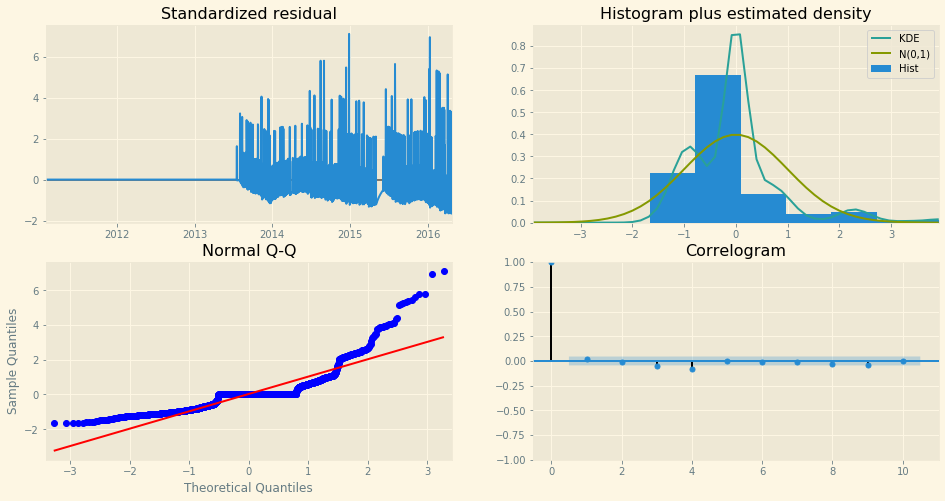

In [28]:
result.plot_diagnostics(figsize=(16,8))
plt.show()

##### Validating forecast

Printing the sales of last 200 days to have a better look at the data and the generated predictions by ARIMA.

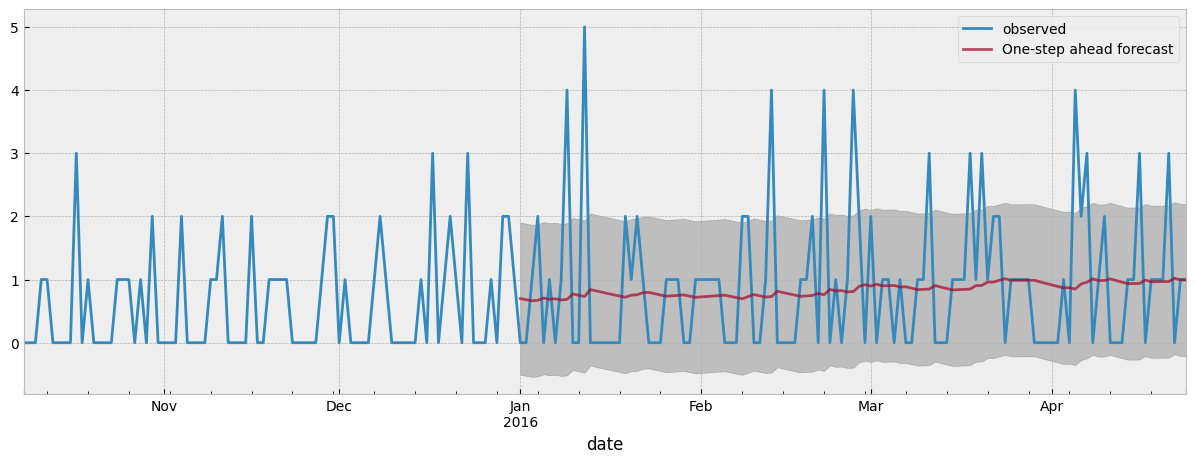

In [27]:
pred = result.get_prediction(start='2016-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax=example['sales'][-200:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=0.7, figsize=(15,5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

Calculating RMSE

In [28]:
y_forecasted = pred.predicted_mean
y_truth = data['2016-01-01':]

In [29]:
rmse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(np.sqrt(rmse), 2))

The Mean Squared Error of our forecasts is 1.1428428530030694


As it can be seen through the graph, the ARIMA model did not really do very well for our data